# Short-term stock data predictive modelling
by Kanru Wang, Sep 2018
<br>
<br>
## Content
* Introduction
* Data Wrangling
    * Group by day and fill NA
* Model Building
    * Random Forest Regressor
        * Parameter Selection
        * Training and Evaluation
    * XGBoost Regressor
        * Parameter Selection
        * Training and Evaluation
* Data Visualisation
    
<br>
<br>

## Introduction
* In this notebook, the predictive model takes the last three hours' data to forecast the price change in percentage 15 minutes from now. 
* It will not be able to make predictions before the noon of a trading day, because it will not have three hours' data by then.
* It is easy to change the code in order to forecast the price change one hour instead of 15 minutes from now.
* It is trained on 30000 training cases sampled from the month of August, and tested on data sampled from the two weeks immediatedly after August. The month August is picked arbitrarily.
* The strategy is simply "very short-term reversal".

In [129]:
import pandas as pd
import numpy as np

import pickle
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import scipy.stats as st

<br>
<br>
Notice that some data is not used in this analysis, because it is likely to be redundant.

In [176]:
close_returns_raw = pd.read_csv('dataset/close_returns.csv', index_col = 0, parse_dates = True)
high_prices_raw = pd.read_csv('dataset/high_prices.csv', index_col = 0, parse_dates = True)
low_prices_raw = pd.read_csv('dataset/low_prices.csv', index_col = 0, parse_dates = True)
volume_raw = pd.read_csv('dataset/volume.csv', index_col = 0, parse_dates = True)
signals_A_raw = pd.read_csv('dataset/signals_A.csv', index_col = 0, parse_dates = True)
signals_B_raw = pd.read_csv('dataset/signals_B.csv', index_col = 0, parse_dates = True)

<br>
<br>
# Data wrangling
<br>
<br>
Each stock's volume is normalised by its median volume of the year. The volume_normalised is a dataframe.

In [177]:
median_volume_each_stock = volume_raw.median(axis = 0)
volume_normalised = volume_raw.apply(lambda x: x / median_volume_each_stock, axis=1)

<br>
<br>
A crude way to measure volatility. Now we have volatility dataframe.

In [178]:
volatility = (high_prices_raw - low_prices_raw) / low_prices_raw

<br>
<br>
### Group by day and fill NA
<br>
Forward filling, maximum 2 x 15 mins gap of missing data. Not to fill the next day by previous day's data.

In [180]:
def intra_day_forward_fillna_max_filling_1_hour_gap(dataframe):
    return dataframe.groupby(dataframe.index.dayofyear).apply(
        lambda x: x.fillna(method = "ffill", axis = 0, limit = 2))

The NA filling step for the "close return" dataframe is skipped.
<br>
<br>
We can wait until after the tidy dataframe is formed and then delete any row that has missing values. We will not suffer from wasting too much data, and there are benefits not to fill NA: 
1. There is no data shortage in this case; there is too much data so that sampling is needed to reduce training time,
<br>
2. Filling NA introduces noise and bias,
<br>
3. When a stock has missing values, perhaps it is due to the stock not being traded; we do not want to trade small cap.

In [181]:
# close_returns_raw_filled = close_returns_raw.groupby(close_returns_raw.index.dayofyear).apply(
#     lambda x: x.fillna(value = 0.0, axis = 0))
# Different from "ffill", if use "limit" here, it would specify maximum total number of 0 
# that can be used to pad each col. Not what we want.
volume_normalised_filled = intra_day_forward_fillna_max_filling_1_hour_gap(volume_normalised)
volatility_filled = intra_day_forward_fillna_max_filling_1_hour_gap(volatility)
signal_A_raw_filled = intra_day_forward_fillna_max_filling_1_hour_gap(signals_A_raw)
signal_B_raw_filled = intra_day_forward_fillna_max_filling_1_hour_gap(signals_B_raw)

<br>
<br>
List of dataframes each is the yearly data of a stock (five columns)

In [183]:
list_of_df_each_for_one_stock = [pd.concat([#close_returns_raw_filled.iloc[:, a],
                                            close_returns_raw.iloc[:, a],
                                            volume_normalised_filled.iloc[:, a],
                                            volatility_filled.iloc[:, a],
                                            signal_A_raw_filled.iloc[:, a],
                                            signal_B_raw_filled.iloc[:, a]], axis = 1)
                                 for a in range(1000)] # Total 1000 stocks

<br>
<br>
Rename each dataframe.

In [184]:
for e in list_of_df_each_for_one_stock:
    e.columns = ["return", "volume", "volatility", "signal_A", "signal_B"]               

<br>
<br>
Take a look.

In [185]:
list_of_df_each_for_one_stock[0].head()

,return,volume,volatility,signal_A,signal_B
time,,,,,
2017-01-03 09:30:00,NaN,1.357828,0.011823,NaN,NaN
2017-01-03 09:45:00,-0.010530,0.840949,0.003595,-0.012937,NaN
2017-01-03 10:00:00,-0.005218,1.191392,0.005506,-0.004742,NaN
2017-01-03 10:15:00,0.004456,0.554745,0.004171,-0.001138,NaN
2017-01-03 10:30:00,-0.001799,0.484170,0.004360,0.003315,NaN


In [186]:
list_of_df_each_for_one_stock[0].tail()

,return,volume,volatility,signal_A,signal_B
time,,,,,
2017-12-29 14:45:00,-0.014195,0.389359,0.000930,-0.014027,0.678396
2017-12-29 15:00:00,-0.005576,0.359596,0.001627,-0.006361,0.653249
2017-12-29 15:15:00,0.006572,0.628543,0.002169,0.005638,1.139014
2017-12-29 15:30:00,-0.005632,1.039431,0.001703,-0.003321,1.790983
2017-12-29 15:45:00,0.011733,5.173711,0.002170,0.011734,6.585453


<br>
<br>
<br>

In [187]:
list_of_df_by_stock_by_day_grouped = [x.groupby(x.index.dayofyear) 
                                      for x in list_of_df_each_for_one_stock]

Remember previously there is a list of dataframes each is the yearly data of a stock (five columns). The list_of_df_by_stock_by_day is a list of dataframes each is the **daily** data of a stock (five columns). 

In [188]:
list_of_df_by_stock_by_day = [x.get_group(a) 
                              for x in list_of_df_by_stock_by_day_grouped 
                              for a in x.groups]

In [189]:
list_of_df_by_stock_by_day[0].tail()

,return,volume,volatility,signal_A,signal_B
time,,,,,
2017-01-03 14:45:00,0.002773,1.267860,0.001912,0.002390,1.559230
2017-01-03 15:00:00,-0.006562,0.902536,0.002672,-0.008265,1.130021
2017-01-03 15:15:00,0.001064,0.785697,0.002004,0.003739,0.969713
2017-01-03 15:30:00,-0.008516,1.212756,0.002479,-0.010592,1.432389
2017-01-03 15:45:00,0.003238,4.798810,0.005139,-0.000370,4.572557


<br>
<br>
Remember previously there is a list of dataframes each is the daily data of a stock. 
<br>
<br>
The list_of_df_by_stock_by_window_flatten is a list of dataframes each is a sliding window of 13 x 15 minutes size over the daily data of a stock.
<br>
<br>
As you will see in the later process, the first 12 x 15 minutes will be features. For the last 1 x 15 minutes, all other values will be discarded, * except the "return" which is what to be forecasted. *
<br>
<br>
The total number of dataframes in list_of_df_by_stock_by_window_flatten should be: * number of sliding windows per day x number of days x number of stocks. *  

In [190]:
window_size = 13

def get_list_of_window_sized_df(df):
    return [df.iloc[i: i + window_size] for i in range(len(df.index) - window_size + 1)]

In [191]:
list_of_df_by_stock_by_window = [get_list_of_window_sized_df(x) 
                                 for x in list_of_df_by_stock_by_day]

In [192]:
list_of_df_by_stock_by_window_flatten = [window 
                                         for by_stock_by_day in list_of_df_by_stock_by_window
                                         for window in by_stock_by_day]

<br>
<br>
An example of such windows.

In [193]:
list_of_df_by_stock_by_window_flatten[0]

,return,volume,volatility,signal_A,signal_B
time,,,,,
2017-01-03 09:30:00,NaN,1.357828,0.011823,NaN,NaN
2017-01-03 09:45:00,-0.010530,0.840949,0.003595,-0.012937,NaN
2017-01-03 10:00:00,-0.005218,1.191392,0.005506,-0.004742,NaN
2017-01-03 10:15:00,0.004456,0.554745,0.004171,-0.001138,NaN
2017-01-03 10:30:00,-0.001799,0.484170,0.004360,0.003315,NaN
2017-01-03 10:45:00,-0.001767,0.742527,0.002465,-0.004975,NaN
2017-01-03 11:00:00,0.000046,1.119380,0.003421,0.002896,NaN
2017-01-03 11:15:00,0.004687,0.694956,0.001901,0.003925,NaN
2017-01-03 11:30:00,-0.003899,0.841778,0.003386,-0.004027,NaN


<br>
<br>
The next step is to transform each window into a row. The list_of_df_by_stock_by_window_flatten_reindexed_unstacked is a list of such rows.

In [194]:
# Will take a long time
list_of_df_by_stock_by_window_flatten_reindexed_unstacked = \
    [window.reset_index().unstack()
     for window in list_of_df_by_stock_by_window_flatten]

<br>
<br>
Concatenate rows into a dataframe.

In [195]:
# Will take a long time
tidy_table = pd.concat(list_of_df_by_stock_by_window_flatten_reindexed_unstacked, axis=1).T

In [196]:
tidy_table.shape

(3506000, 78)

In [197]:
tidy_table.head()

time                                            \
                    0                    1                    2    
0  2017-01-03 09:30:00  2017-01-03 09:45:00  2017-01-03 10:00:00   
1  2017-01-03 09:45:00  2017-01-03 10:00:00  2017-01-03 10:15:00   
2  2017-01-03 10:00:00  2017-01-03 10:15:00  2017-01-03 10:30:00   
3  2017-01-03 10:15:00  2017-01-03 10:30:00  2017-01-03 10:45:00   
4  2017-01-03 10:30:00  2017-01-03 10:45:00  2017-01-03 11:00:00   

                                                                  \
                    3                    4                    5    
0  2017-01-03 10:15:00  2017-01-03 10:30:00  2017-01-03 10:45:00   
1  2017-01-03 10:30:00  2017-01-03 10:45:00  2017-01-03 11:00:00   
2  2017-01-03 10:45:00  2017-01-03 11:00:00  2017-01-03 11:15:00   
3  2017-01-03 11:00:00  2017-01-03 11:15:00  2017-01-03 11:30:00   
4  2017-01-03 11:15:00  2017-01-03 11:30:00  2017-01-03 11:45:00   

                                                                  \
                    6                    7                    8    
0  2017-01-03 11:00:00  2017-01-03 11:15:00  2017-01-03 11:30:00   
1  2017-01-03 11:15:00  2017-01-03 11:30:00  2017-01-03 11:45:00   
2  2017-01-03 11:30:00  2017-01-03 11:45:00  2017-01-03 12:00:00   
3  2017-01-03 11:45:00  2017-01-03 12:00:00  2017-01-03 12:15:00   
4  2017-01-03 12:00:00  2017-01-03 12:15:00  2017-01-03 12:30:00   

                          ...    signal_B                                    \
                    9     ...          3    4        5         6         7    
0  2017-01-03 11:45:00    ...         NaN  NaN      NaN       NaN       NaN   
1  2017-01-03 12:00:00    ...         NaN  NaN      NaN       NaN       NaN   
2  2017-01-03 12:15:00    ...         NaN  NaN      NaN       NaN   1.15869   
3  2017-01-03 12:30:00    ...         NaN  NaN      NaN   1.15869  0.773829   
4  2017-01-03 12:45:00    ...         NaN  NaN  1.15869  0.773829   0.75454   

                                                     
         8         9         10        11        12  
0       NaN   1.15869  0.773829   0.75454   1.99192  
1   1.15869  0.773829   0.75454   1.99192  0.594899  
2  0.773829   0.75454   1.99192  0.594899  0.799001  
3   0.75454   1.99192  0.594899  0.799001   0.47083  
4   1.99192  0.594899  0.799001   0.47083  0.701983  

[5 rows x 78 columns]

<br>
<br>
Save the result.

In [198]:
with open('tidy_table_return_not_filled.pickle', 'wb') as handle:
    pickle.dump(tidy_table, handle, protocol = pickle.HIGHEST_PROTOCOL)

#with open('tidy_table_return_not_filled.pickle', 'rb') as handle:
#    tidy_table = pickle.load(handle)

<br>
<br>
Flatten the index.

In [199]:
tidy_table.columns = [col[0] + '_' + str(col[1]) for col in tidy_table.columns.values]

<br>
<br>
Drop useless columns and * drop any row that has any missing value. *

In [200]:
tidy_table_dropped = tidy_table.drop(['time_0', 'time_1', 'time_2', 'time_3', 'time_4', 'time_5',
                                      'time_6', 'time_7', 'time_8', 'time_9', 'time_10', 'time_11',
                                      'volume_12', 'volatility_12', 'signal_A_12', 'signal_B_12'], axis = 1)\
                               .dropna(axis = 0)

In [201]:
tidy_table_dropped.shape

(2711538, 62)

<br>
<br>
Notice that "return_12" is the value to be predicted.

In [202]:
tidy_table_dropped.columns.values

array(['time_12', 'return_0', 'return_1', 'return_2', 'return_3',
       'return_4', 'return_5', 'return_6', 'return_7', 'return_8',
       'return_9', 'return_10', 'return_11', 'return_12', 'volume_0',
       'volume_1', 'volume_2', 'volume_3', 'volume_4', 'volume_5',
       'volume_6', 'volume_7', 'volume_8', 'volume_9', 'volume_10',
       'volume_11', 'volatility_0', 'volatility_1', 'volatility_2',
       'volatility_3', 'volatility_4', 'volatility_5', 'volatility_6',
       'volatility_7', 'volatility_8', 'volatility_9', 'volatility_10',
       'volatility_11', 'signal_A_0', 'signal_A_1', 'signal_A_2',
       'signal_A_3', 'signal_A_4', 'signal_A_5', 'signal_A_6',
       'signal_A_7', 'signal_A_8', 'signal_A_9', 'signal_A_10',
       'signal_A_11', 'signal_B_0', 'signal_B_1', 'signal_B_2',
       'signal_B_3', 'signal_B_4', 'signal_B_5', 'signal_B_6',
       'signal_B_7', 'signal_B_8', 'signal_B_9', 'signal_B_10',
       'signal_B_11'], dtype=object)

<br>
<br>
Define a function to generate more features. Specifically:
* Rowing sum of 2 x 15 minutes window size
* Rowing sum of 4 x 15 minutes window size
* Rowing sum of 8 x 15 minutes window size
* Rowing sum of 12 x 15 minutes window size

In [347]:
def add_more_rolling_features(df, string):
    df[string + "_0_1"] = df[string + "_0"] + df[string + "_1"]
    df[string + "_1_2"] = df[string + "_1"] + df[string + "_2"]
    df[string + "_2_3"] = df[string + "_2"] + df[string + "_3"]
    df[string + "_3_4"] = df[string + "_3"] + df[string + "_4"]
    df[string + "_4_5"] = df[string + "_4"] + df[string + "_5"]
    df[string + "_5_6"] = df[string + "_5"] + df[string + "_6"]
    df[string + "_6_7"] = df[string + "_6"] + df[string + "_7"]
    df[string + "_7_8"] = df[string + "_7"] + df[string + "_8"]
    df[string + "_8_9"] = df[string + "_8"] + df[string + "_9"]
    df[string + "_9_10"] = df[string + "_9"] + df[string + "_10"]
    df[string + "_10_11"] = df[string + "_10"] + df[string + "_11"]
    
    df[string + "_0_to_3"] = df[string + "_0"] + df[string + "_1"] + df[string + "_2"] + df[string + "_3"]
    df[string + "_1_to_4"] = df[string + "_1"] + df[string + "_2"] + df[string + "_3"] + df[string + "_4"]
    df[string + "_2_to_5"] = df[string + "_2"] + df[string + "_3"] + df[string + "_4"] + df[string + "_5"]
    df[string + "_3_to_6"] = df[string + "_3"] + df[string + "_4"] + df[string + "_5"] + df[string + "_6"]
    df[string + "_4_to_7"] = df[string + "_4"] + df[string + "_5"] + df[string + "_6"] + df[string + "_7"]
    df[string + "_5_to_8"] = df[string + "_5"] + df[string + "_6"] + df[string + "_7"] + df[string + "_8"]
    df[string + "_6_to_9"] = df[string + "_6"] + df[string + "_7"] + df[string + "_8"] + df[string + "_9"]
    df[string + "_7_to_10"] = df[string + "_7"] + df[string + "_8"] + df[string + "_9"] + df[string + "_10"]
    df[string + "_8_to_11"] = df[string + "_8"] + df[string + "_9"] + df[string + "_10"] + df[string + "_11"]
    
    df[string + "_0_to_7"] = df[string + "_0"] + df[string + "_1"] + df[string + "_2"] + df[string + "_3"] +\
                             df[string + "_4"] + df[string + "_5"] + df[string + "_6"] + df[string + "_7"]
    df[string + "_1_to_8"] = df[string + "_1"] + df[string + "_2"] + df[string + "_3"] + df[string + "_4"] +\
                             df[string + "_5"] + df[string + "_6"] + df[string + "_7"] + df[string + "_8"]
    df[string + "_2_to_9"] = df[string + "_2"] + df[string + "_3"] + df[string + "_4"] + df[string + "_5"] +\
                             df[string + "_6"] + df[string + "_7"] + df[string + "_8"] + df[string + "_9"]
    df[string + "_3_to_10"] = df[string + "_3"] + df[string + "_4"] + df[string + "_5"] + df[string + "_6"] +\
                              df[string + "_7"] + df[string + "_8"] + df[string + "_9"] + df[string + "_10"]
    df[string + "_4_to_11"] = df[string + "_4"] + df[string + "_5"] + df[string + "_6"] + df[string + "_7"] +\
                              df[string + "_8"] + df[string + "_9"] + df[string + "_10"] + df[string + "_11"]
    
    df[string + "_0_to_11"] = df[string + "_0"] + df[string + "_1"] + df[string + "_2"] + df[string + "_3"] +\
                              df[string + "_4"] + df[string + "_5"] + df[string + "_6"] + df[string + "_7"] +\
                              df[string + "_8"] + df[string + "_9"] + df[string + "_10"] + df[string + "_11"]
    return df

<br>
<br>
Apply this feature generation function to all five types of features.
<br>
Additionally:
* "hour" might be a useful feature. 
* "dayofweek" might be useful if the training data is from a longer time window, but with a window of just one month, it may introduce bias.

In [348]:
tidy_more_features = tidy_table_dropped.assign(hour = lambda x: x["time_12"].apply(lambda x: x.hour))#,
#                                               dayofweek = lambda x: x["time_12"].apply(lambda x: x.dayofweek))
tidy_more_features = add_more_rolling_features(tidy_more_features, "return")
tidy_more_features = add_more_rolling_features(tidy_more_features, "volume")
tidy_more_features = add_more_rolling_features(tidy_more_features, "volatility")
tidy_more_features = add_more_rolling_features(tidy_more_features, "signal_A")
tidy_more_features = add_more_rolling_features(tidy_more_features, "signal_B")

<br>
<br>
As the rowing sum of 2 x 15 minutes window size already exist, delete some granular columns.

In [349]:
tidy_more_features = tidy_more_features.drop(
      ['return_0', 'return_1', 'return_2', 'return_3', 'return_4', 'return_5', 
       'return_6', 'return_7', #'return_8', 'return_9', 'return_10',                         
       'volume_0', 'volume_1', 'volume_2', 'volume_3', 'volume_4', 'volume_5',
       'volume_6', 'volume_7', #'volume_8', 'volume_9', 'volume_10',
       'volatility_0', 'volatility_1', 'volatility_2', 'volatility_3', 'volatility_4', 'volatility_5', 
       'volatility_6', 'volatility_7', #'volatility_8', 'volatility_9', 'volatility_10',
       'signal_A_0', 'signal_A_1', 'signal_A_2', 'signal_A_3', 'signal_A_4', 'signal_A_5', 
       'signal_A_6', 'signal_A_7', #'signal_A_8', 'signal_A_9', 'signal_A_10',
       'signal_B_0', 'signal_B_1', 'signal_B_2', 'signal_B_3', 'signal_B_4', 'signal_B_5', 
       'signal_B_6', 'signal_B_7'#, 'signal_B_8', 'signal_B_9', 'signal_B_10'
      ], axis = 1)

In [350]:
tidy_more_features.shape

(2711538, 153)

<br>
<br>
"time_12" is the time associated with "return_12", and "return_12" is the value to be predicted.
<br>
<br>
Train on 30000 training cases sampled from the month of August, and test on data sampled from the two weeks immediatedly after August.

In [351]:
tidy_more_features = tidy_more_features.reset_index(drop = True)
start_of_aug = datetime.strptime('2017-08-01 06:00:00', '%Y-%m-%d %H:%M:%S')
end_of_aug = datetime.strptime('2017-08-31 18:00:00', '%Y-%m-%d %H:%M:%S')
mid_of_sep = datetime.strptime('2017-09-15 18:00:00', '%Y-%m-%d %H:%M:%S')
train_data = tidy_more_features.loc[start_of_aug < tidy_more_features['time_12']].\
                                loc[tidy_more_features['time_12'] < end_of_aug].sample(n = 30000)
test_data = tidy_more_features.loc[end_of_aug < tidy_more_features['time_12']].\
                               loc[tidy_more_features['time_12'] < mid_of_sep].sample(n = 20000)

<br>
<br>
No longer need the time column, so drop it. The apply(pd.to_numeric) is for assurance.

In [352]:
train_data = train_data.drop("time_12", axis = 1).apply(pd.to_numeric)
test_data = test_data.drop("time_12", axis = 1).apply(pd.to_numeric)

In [353]:
train_data.shape

(30000, 152)

In [383]:
test_data.shape

(20000, 152)

In [355]:
train_data.columns.values

array(['return_8', 'return_9', 'return_10', 'return_11', 'return_12',
       'volume_8', 'volume_9', 'volume_10', 'volume_11', 'volatility_8',
       'volatility_9', 'volatility_10', 'volatility_11', 'signal_A_8',
       'signal_A_9', 'signal_A_10', 'signal_A_11', 'signal_B_8',
       'signal_B_9', 'signal_B_10', 'signal_B_11', 'hour', 'return_0_1',
       'return_1_2', 'return_2_3', 'return_3_4', 'return_4_5',
       'return_5_6', 'return_6_7', 'return_7_8', 'return_8_9',
       'return_9_10', 'return_10_11', 'return_0_to_3', 'return_1_to_4',
       'return_2_to_5', 'return_3_to_6', 'return_4_to_7', 'return_5_to_8',
       'return_6_to_9', 'return_7_to_10', 'return_8_to_11',
       'return_0_to_7', 'return_1_to_8', 'return_2_to_9',
       'return_3_to_10', 'return_4_to_11', 'return_0_to_11', 'volume_0_1',
       'volume_1_2', 'volume_2_3', 'volume_3_4', 'volume_4_5',
       'volume_5_6', 'volume_6_7', 'volume_7_8', 'volume_8_9',
       'volume_9_10', 'volume_10_11', 'volume_0_to_3', '

<br>
<br>
<br>
<br>
<br>
<br>

# Model building

Two models are used and compared, which are Random Forest Regressor and XGBoost Regressor. 
* They are both flexible enough to benefit from data of large volume.
* They are both fast to train.
* They do not require data normalization/standardization.
* They are less likely to overfit.

Regarding feature selection and avoiding over-fitting
* Randomized combination of hyper-parameters.
* Find the best hyper-parameter setting based on the result of five-fold cross validation.


## Random Forest Regressor
Again, "return_12" is the "y variable" column.

In [212]:
params = {
    "n_estimators" : [30],
    "max_features" : ["auto", "sqrt", "log2"],
    "max_depth" : [25, 30, 35],
    "min_samples_split" : [2, 3, 5],
    "min_samples_leaf" : [1, 2, 3]
}

model = RandomForestRegressor(n_jobs = -1)

gs = RandomizedSearchCV(estimator = model, 
                        param_distributions = params, 
                        n_jobs = -1, 
                        n_iter = 12,
                        cv = 5,
                        return_train_score = False)

gs.fit(train_data.loc[:, train_data.columns != "return_12"], train_data.loc[:, "return_12"])

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=12, n_jobs=-1,
          param_distributions={'n_estimators': [30], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [25, 30, 35], 'min_samples_split': [2, 3, 5], 'min_samples_leaf': [1, 2, 3]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=False, scoring=None, verbose=0)

In [213]:
print(datetime.now())

2018-09-23 10:28:57.776439


<br>
<br>
1. Print the cv result, sort it, and find the hyper-parameters that demonstrate areas of improvement. 
<br>
2. Edit the allowed hyper-parameters sapce in the previous chunk to rerun it. 
<br>
3. After a few iterations, pick the best hyper-parameter setting.

In [214]:
#pd.DataFrame.from_dict(gs.cv_results_)
gs.grid_scores_

C:\Users\wangka3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.25492, std: 0.01358, params: {'n_estimators': 30, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 30},
 mean: 0.25690, std: 0.01386, params: {'n_estimators': 30, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 35},
 mean: 0.25665, std: 0.00975, params: {'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 35},
 mean: 0.24840, std: 0.01174, params: {'n_estimators': 30, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 35},
 mean: 0.25242, std: 0.01265, params: {'n_estimators': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30},
 mean: 0.24656, std: 0.01313, params: {'n_estimators': 30, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30},
 mean: 0.25019, std: 0.01520, params: {'n_estimators': 30, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_f

<br>
<br>
Initiate a RandomForestRegressor model based on the best hyper-parameter setting.

In [565]:
best_model = RandomForestRegressor(
    n_estimators = 50,
    max_features = "log2",
    max_depth = 30,
    min_samples_split = 3,
    min_samples_leaf = 2,
    n_jobs = -1    
)

<br>
<br>
Train the model on the entire training set.

In [545]:
best_model.fit(train_data.loc[:, train_data.columns != "return_12"], train_data.loc[:, "return_12"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

<br>
<br>
Predict

In [546]:
prediction = best_model.predict(test_data.loc[:, test_data.columns != "return_12"])

<br>
<br>
Setting the plot size. Once for all.

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

<br>
<br>
How is the prediction

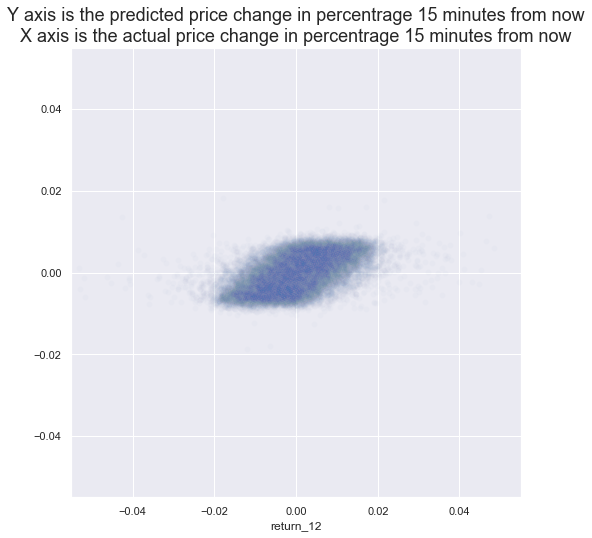

In [387]:
pyplot.axis('scaled')
sns.scatterplot(x = test_data.loc[:, "return_12"], y = prediction, alpha = 0.02).\
set_title('Y axis is the predicted price change in percentrage 15 minutes from now\n\
X axis is the actual price change in percentrage 15 minutes from now',fontsize = 18);

<br>
<br>
Measure in a single number

In [547]:
root_mean_square_error = mean_squared_error(test_data.loc[:, "return_12"], prediction) ** 0.5
root_mean_square_error

0.008025808617511726

<br>
<br>
Feature importance. Notice that only the top 30 most important features are displayed.

Feature ranking:
1. feature return_11 (0.053373)
2. feature return_10_11 (0.039176)
3. feature signal_A_11 (0.038340)
4. feature return_8_to_11 (0.028731)
5. feature signal_A_8_to_11 (0.027333)
6. feature signal_A_10_11 (0.026353)
7. feature signal_A_4_to_11 (0.025406)
8. feature return_4_to_11 (0.024232)
9. feature return_0_to_11 (0.015395)
10. feature signal_A_0_to_11 (0.010182)
11. feature signal_A_10 (0.008796)
12. feature return_8 (0.008532)
13. feature return_10 (0.008505)
14. feature signal_A_3_to_10 (0.007404)
15. feature return_4_5 (0.007311)
16. feature return_4_to_7 (0.007242)
17. feature return_9 (0.007230)
18. feature volatility_10_11 (0.007159)
19. feature return_8_9 (0.007124)
20. feature volatility_11 (0.006743)
21. feature signal_A_9_10 (0.006646)
22. feature return_9_10 (0.006551)
23. feature return_0_1 (0.006496)
24. feature return_6_to_9 (0.006328)
25. feature signal_A_7_to_10 (0.006328)
26. feature signal_A_4_to_7 (0.006313)
27. feature signal_A_8_9 (0.006298)
28. 

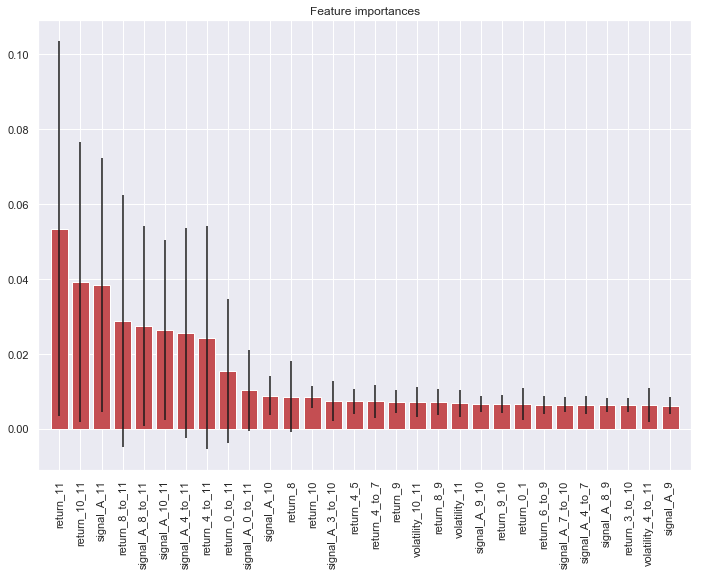

In [377]:
X = test_data.loc[:, test_data.columns != "return_12"]

importances = best_model.feature_importances_

std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)

indices = np.argsort(importances)[::-1][0:30]

# Print the feature ranking
print("Feature ranking:")

for f in range(30):
    print("%d. feature %s (%f)" % (f + 1, X.columns.values[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
pyplot.figure()
pyplot.title("Feature importances")
pyplot.bar(range(30), importances[indices], color="r", yerr=std[indices], align="center")
pyplot.xticks(range(30), X.columns.values[indices], rotation= 90)
pyplot.xlim([-1, 30])
pyplot.show()

<br>
<br>
<br>
<br>
What if we only skim 200 out of 20000 test data points due to their higher predicted growth...

In [548]:
result = pd.DataFrame([test_data.loc[:, "return_12"].reset_index(drop = True), prediction]).T
result.columns.values[1] = "prediction"
result = result.sort_values(by = "prediction", ascending = False)
best_one_percent_opportunities = result.iloc[0:200, :]

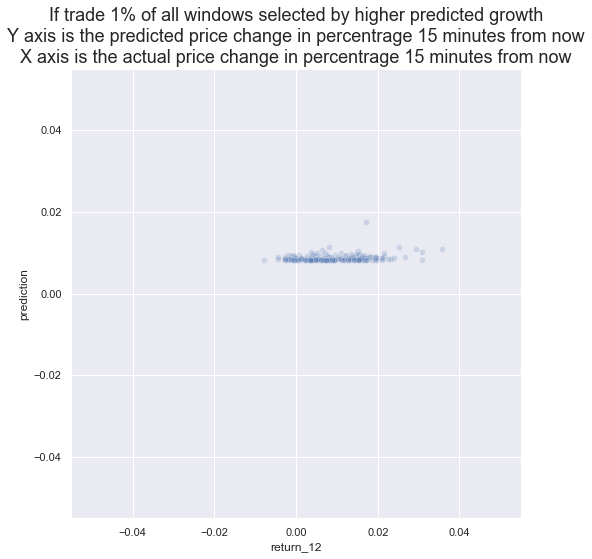

In [549]:
pyplot.axis('scaled')
sns.scatterplot(x = "return_12", y = "prediction", data  = best_one_percent_opportunities, alpha = 0.2).\
set_title('If trade 1% of all windows selected by higher predicted growth\n\
Y axis is the predicted price change in percentrage 15 minutes from now\n\
X axis is the actual price change in percentrage 15 minutes from now',fontsize = 18);

<br>
<br>
<br>
<br>
Let's train 50 such models to see if such models' performance is stable. Still, we only skim 200 out of 20000 test data points due to their higher predicted growth...

In [530]:
# This code will allocate fund proportionally to the predicted growth...
#invested_amount = best_one_percent_opportunities['prediction']
#amount_after_buy_n_sell = invested_amount * (best_one_percent_opportunities['return_12'] + 1)
#(np.sum(amount_after_buy_sell) / np.sum(invested_amount)) - 1

In [566]:
list_of_mean_return_rf = []

for e in range(50):
    best_model.fit(train_data.loc[:, train_data.columns != "return_12"], train_data.loc[:, "return_12"])
    prediction = best_model.predict(test_data.loc[:, test_data.columns != "return_12"])
    result = pd.DataFrame([test_data.loc[:, "return_12"].reset_index(drop = True), prediction]).T
    result.columns.values[1] = "prediction"
    result = result.sort_values(by = "prediction", ascending = False)
    best_one_percent_opportunities = result.iloc[0:200, :]
    list_of_mean_return_rf.append(np.mean(best_one_percent_opportunities['return_12']))

In [537]:
np.mean(list_of_mean_return_rf)

0.008533444328914667

In [567]:
np.std(list_of_mean_return_rf)

0.0006504380464399619

Without presenting the details of the trials, it is known that if we allocate fund proportionally to the predicted growth, the result can be quite volatile. 
<br>
<br>
On the other hand, as shown in the above, if we allocate fund evenly among those 200 opportunities, we will have on average a 0.85% growth on the fund after the two week period where the 20000 test data points are sampled, and such growth is stable (0.00065 standard deviation). 
<br>
<br>
That is not an impressive return, even before taking spreads, fees and market impact if orders are large into the consideration. 
<br>
<br>
However, notice that in this calculation, each proportion of fund is used only once in these two weeks. We can use the same fund 200 times, assuming that opportunities do not appear at the same time. Also, there are more than 200 opportunities in these two weeks because the test data is sampled.

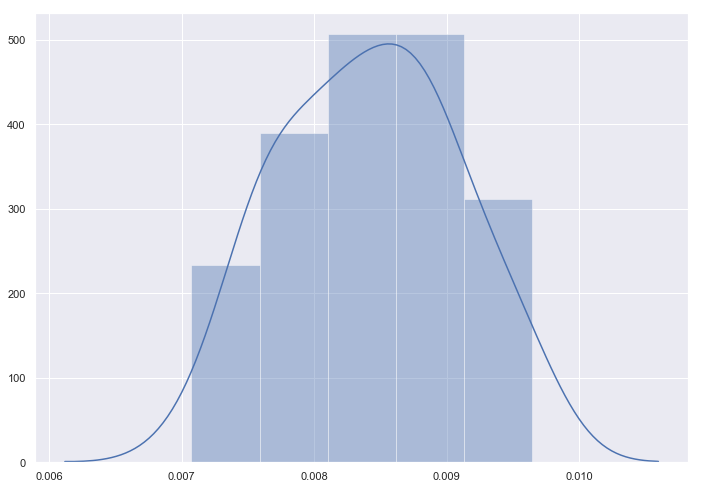

In [568]:
sns.distplot(list_of_mean_return_rf);

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
## XGBoost Regressor

In [331]:
params = {
    "n_estimators": [30],
    "max_depth": st.randint(10, 30),
    "learning_rate": st.uniform(0.3, 0.4),
    "colsample_bytree": st.uniform(0.50, 0.50),
    "subsample": st.uniform(0.9, 0.1),
    "gamma": st.uniform(0, 0.02),
    "min_child_weight": [0,1,2,3,4],
    "max_delta_step": [0, 1, 2, 3, 4]
}

model = XGBRegressor(n_jobs = -1)

gs = RandomizedSearchCV(estimator = model, 
                        param_distributions = params, 
                        n_jobs = -1, 
                        n_iter = 12,
                        cv = 5,
                        return_train_score = False)

gs.fit(train_data.loc[:, train_data.columns != "return_12"], train_data.loc[:, "return_12"])

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=12, n_jobs=-1,
          param_distributions={'n_estimators': [30], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024ACD944908>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024ACD944B00>, 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at ...ject at 0x0000025301823668>, 'min_child_weight': [0, 1, 2, 3, 4], 'max_delta_step': [0, 1, 2, 3, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          

In [332]:
print(datetime.now())

2018-09-23 16:25:25.789055


<br>
<br>
1. Print the cv result, sort it, and find the hyper-parameters that demonstrate areas of improvement. 
<br>
2. Edit the allowed hyper-parameters sapce in the previous chunk to rerun it. 
<br>
3. After a few iterations, pick the best hyper-parameter setting.

In [333]:
gs.grid_scores_

C:\Users\wangka3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.25451, std: 0.01601, params: {'colsample_bytree': 0.6137569116170327, 'gamma': 0.004272287874001448, 'learning_rate': 0.39043876285656737, 'max_delta_step': 3, 'max_depth': 22, 'min_child_weight': 0, 'n_estimators': 30, 'subsample': 0.9407619512881008},
 mean: 0.24350, std: 0.01945, params: {'colsample_bytree': 0.8267952752675759, 'gamma': 0.008203313538345263, 'learning_rate': 0.47881515323060486, 'max_delta_step': 2, 'max_depth': 16, 'min_child_weight': 3, 'n_estimators': 30, 'subsample': 0.9116298825928639},
 mean: 0.25835, std: 0.02245, params: {'colsample_bytree': 0.8317559250464839, 'gamma': 0.0018124549229107069, 'learning_rate': 0.31275746586092207, 'max_delta_step': 4, 'max_depth': 13, 'min_child_weight': 4, 'n_estimators': 30, 'subsample': 0.9988916617607422},
 mean: 0.24330, std: 0.01632, params: {'colsample_bytree': 0.8253170305393344, 'gamma': 0.01012629672211921, 'learning_rate': 0.474113471819442, 'max_delta_step': 0, 'max_depth': 23, 'min_child_weight': 1, 'n_e

<br>
<br>
Initiate a XGBRegressor model based on the best hyper-parameter setting.

In [550]:
best_model = XGBRegressor(
    n_estimators = 50,
    max_depth = 22,
    learning_rate = 0.390438763,
    colsample_bytree = 0.613756912,
    subsample = 0.9407619512881008,
    gamma = 0.004272288,
    min_child_weight = 0,
    max_delta_step = 3,
    n_jobs = -1    
)

<br>
<br>
Train the model on the entire training set.

In [476]:
best_model.fit(train_data.loc[:, train_data.columns != "return_12"], train_data.loc[:, "return_12"])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.613756912, gamma=0.004272288,
       learning_rate=0.390438763, max_delta_step=3, max_depth=22,
       min_child_weight=0, missing=None, n_estimators=50, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9407619512881008)

<br>
<br>
Predict

In [477]:
prediction = best_model.predict(test_data.loc[:, test_data.columns != "return_12"])

<br>
<br>
How is the prediction

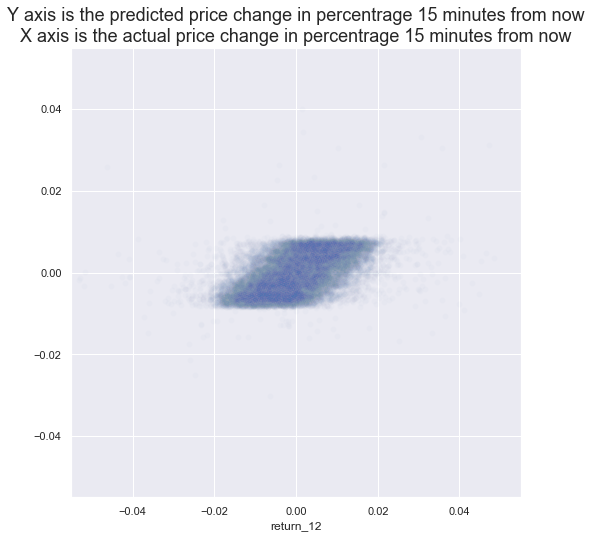

In [478]:
pyplot.axis('scaled')
sns.scatterplot(x = test_data.loc[:, "return_12"], y = prediction, alpha = 0.02).\
set_title('Y axis is the predicted price change in percentrage 15 minutes from now\n\
X axis is the actual price change in percentrage 15 minutes from now',fontsize = 18);

<br>
<br>
Measure in a single number

In [479]:
root_mean_square_error = mean_squared_error(test_data.loc[:, "return_12"], prediction) ** 0.5
root_mean_square_error

0.008063549018882097

<br>
<br>
Feature importance. Notice that only the top 30 most important features are displayed.

Feature ranking:
1. feature return_11 (0.194030)
2. feature return_8_to_11 (0.074627)
3. feature signal_A_10_11 (0.059701)
4. feature return_2_3 (0.059701)
5. feature return_0_to_11 (0.044776)
6. feature return_10_11 (0.044776)
7. feature signal_A_9 (0.029851)
8. feature return_4_to_11 (0.029851)
9. feature signal_A_7_to_10 (0.029851)
10. feature signal_A_8_to_11 (0.029851)
11. feature return_6_7 (0.029851)
12. feature return_4_5 (0.029851)
13. feature signal_A_4_to_11 (0.029851)
14. feature return_8 (0.014925)
15. feature signal_B_1_2 (0.014925)
16. feature return_9_10 (0.014925)
17. feature volume_8 (0.014925)
18. feature signal_A_6_to_9 (0.014925)
19. feature volatility_1_2 (0.014925)
20. feature return_5_6 (0.014925)
21. feature signal_A_6_7 (0.014925)
22. feature signal_A_5_6 (0.014925)
23. feature volatility_3_to_6 (0.014925)
24. feature volatility_10 (0.014925)
25. feature signal_A_0_to_11 (0.014925)
26. feature volatility_8_to_11 (0.014925)
27. feature volatility_0_to_7 (0.0149

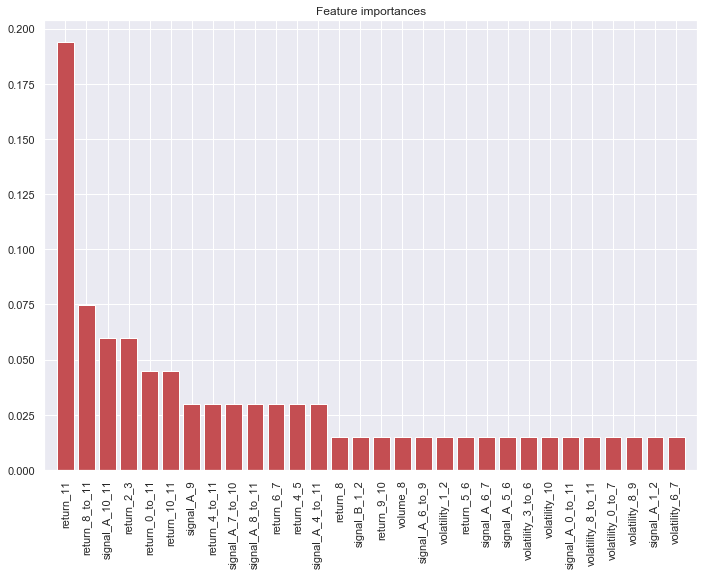

In [367]:
X = test_data.loc[:, test_data.columns != "return_12"]

importances = best_model.feature_importances_

indices = np.argsort(importances)[::-1][0:30]

# Print the feature ranking
print("Feature ranking:")

for f in range(30):
    print("%d. feature %s (%f)" % (f + 1, X.columns.values[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
pyplot.figure()
pyplot.title("Feature importances")
pyplot.bar(range(30), importances[indices], color="r", align="center")
pyplot.xticks(range(30), X.columns.values[indices], rotation= 90)
pyplot.xlim([-1, 30])
pyplot.show()

<br>
<br>
<br>
<br>
Let's train 50 such models to see if such models' performance is stable. Still, we only skim 200 out of 20000 test data points due to their higher predicted growth...

In [558]:
list_of_mean_return_xgb = []

for e in range(50):
    best_model = XGBRegressor(
    n_estimators = 50,
    max_depth = 22,
    learning_rate = 0.390438763,
    colsample_bytree = 0.613756912,
    subsample = 0.9407619512881008,
    gamma = 0.004272288,
    min_child_weight = 0,
    max_delta_step = 3,
    random_state = e,
    n_jobs = -1    
    )
    best_model.fit(train_data.loc[:, train_data.columns != "return_12"], train_data.loc[:, "return_12"])
    prediction = best_model.predict(test_data.loc[:, test_data.columns != "return_12"])
    result = pd.DataFrame([test_data.loc[:, "return_12"].reset_index(drop = True), prediction]).T
    result.columns.values[1] = "prediction"
    result = result.sort_values(by = "prediction", ascending = False)
    best_one_percent_opportunities = result.iloc[0:200, :]
    list_of_mean_return_xgb.append(np.mean(best_one_percent_opportunities['return_12']))

In [559]:
np.mean(list_of_mean_return_xgb)

0.008314402621623635

In [562]:
np.std(list_of_mean_return_xgb)

0.0008095570730172326

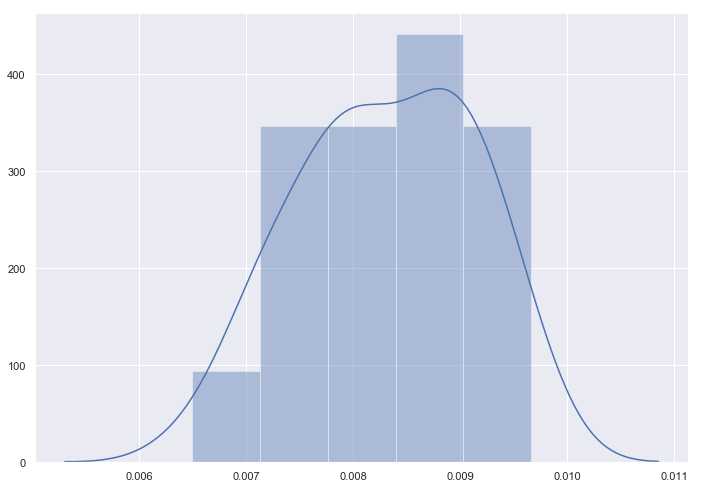

In [560]:
sns.distplot(list_of_mean_return_xgb);

<br>
<br>
As shown in the above, if we allocate fund evenly among those 200 opportunities, we will have on average a 0.83% growth on the fund after the two week period where the 20000 test data points are sampled, with a 0.00081 standard deviation. 
<br>
<br>
Remember that when using Random Forest Regressor, we have on average a 0.85% growth on the fund after those two weeks, with 0.00065 standard deviation.
<br>
<br>
As per the analysis done, Random Forest Regressor is slightly better than XGBoost Regressor due to having lower standard deviation.

In [570]:
st.ttest_ind(list_of_mean_return_rf, list_of_mean_return_xgb, equal_var = False)

Ttest_indResult(statistic=0.7049931064200687, pvalue=0.4825641684113895)

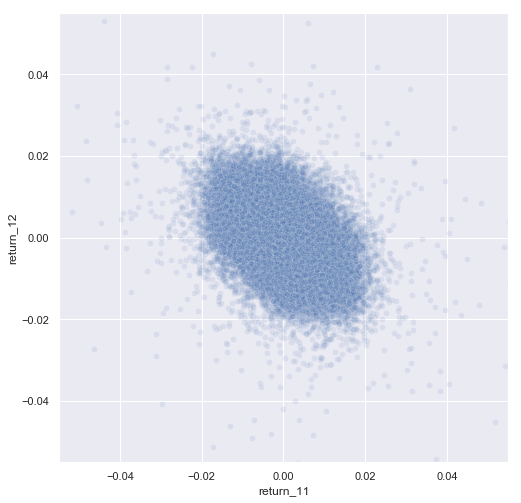

In [234]:
pyplot.axis('scaled')
sns.scatterplot(x = "return_11", y = "return_12", data = train_data, alpha = 0.1);

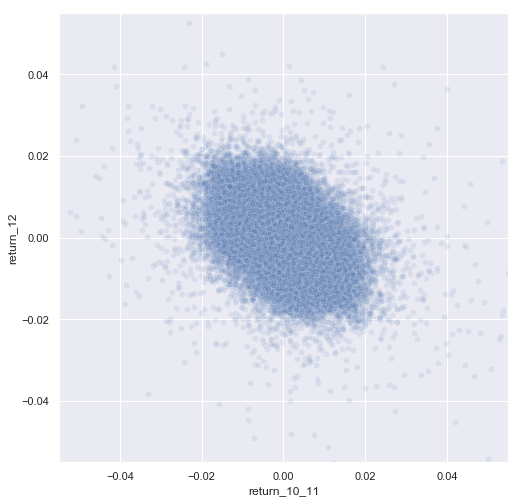

In [235]:
pyplot.axis('scaled')
sns.scatterplot(x = "return_10_11", y = "return_12", data = train_data, alpha = 0.1);

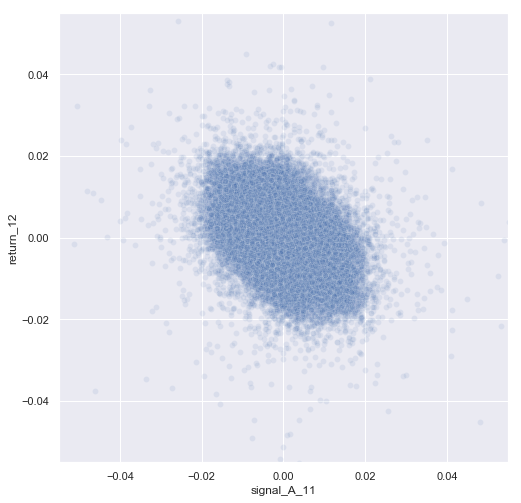

In [236]:
pyplot.axis('scaled')
sns.scatterplot(x = "signal_A_11", y = "return_12", data = train_data, alpha = 0.1);

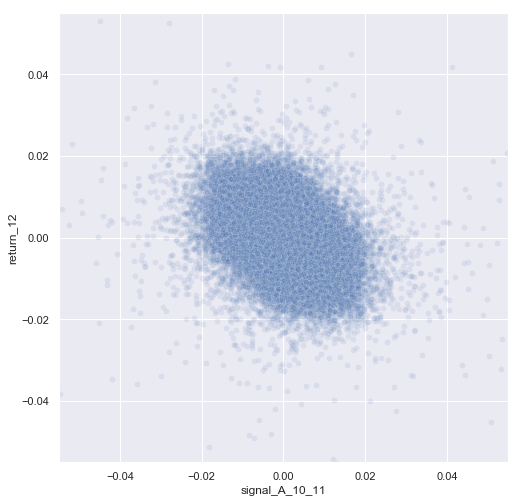

In [237]:
pyplot.axis('scaled')
sns.scatterplot(x = "signal_A_10_11", y = "return_12", data = train_data, alpha = 0.1);